In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import boto3
import requests
import s3fs

In [51]:
bucket = "info7374s3alycefinalproject"
file_name = "gasoline.csv"

In [52]:
s3 = boto3.resource('s3',
                    # ,aws_session_token = aws_session_token,
                    aws_access_key_id = '',
                    aws_secret_access_key = '',
                    region_name = 'us-east-1'
                    )

In [53]:
s3 = boto3.client('s3') 

In [54]:
obj = s3.get_object(Bucket= bucket, Key= file_name)

In [55]:
sales = pd.read_csv(obj['Body'])

In [56]:
sales.head()

,Total_revenue
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


In [57]:
sales['Total_revenue_lag1'] = sales['Total_revenue'].shift(1)
sales['Total_revenue_lag2'] = sales['Total_revenue'].shift(2)
sales['Total_revenue_lag3'] = sales['Total_revenue'].shift(3)
sales['Total_revenue_lag4'] = sales['Total_revenue'].shift(4)
sales['trend'] = np.arange(len(sales))
sales['log_trend'] = np.log1p(np.arange(len(sales)))
sales['sq_trend'] = np.arange(len(sales)) ** 2
weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(sales)], prefix='week')
sales = pd.concat([sales, weeks], axis=1)

In [58]:
sales = sales.iloc[4:, ]
split_train = int(len(sales) * 0.6)
split_test = int(len(sales) * 0.8)

train_y = sales['Total_revenue'][:split_train]
train_X = sales.drop('Total_revenue', axis=1).iloc[:split_train, ].as_matrix()
validation_y = sales['Total_revenue'][split_train:split_test]
validation_X = sales.drop('Total_revenue', axis=1).iloc[split_train:split_test, ].as_matrix()
test_y = sales['Total_revenue'][split_test:]
test_X = sales.drop('Total_revenue', axis=1).iloc[split_test:, ].as_matrix()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [59]:
print(test_X)

[[9004. 9172. 8752. ...    0.    0.    0.]
 [8985. 9004. 9172. ...    0.    0.    0.]
 [9056. 8985. 9004. ...    0.    0.    0.]
 ...
 [9306. 9170. 9089. ...    0.    0.    0.]
 [9024. 9306. 9170. ...    0.    0.    0.]
 [9175. 9024. 9306. ...    0.    0.    0.]]


In [60]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

In [61]:
payload= np2csv(test_X)

In [62]:
r=requests.post("https://asfk7ybx5c.execute-api.us-east-1.amazonaws.com/final/sales", data =json.dumps(payload))

In [63]:
type(r.content)

bytes

In [64]:
result = json.loads(r.content)

In [65]:
one_step = np.array([r['score'] for r in result['predictions']])

One-step-ahead MdAPE =  0.020360223119258346


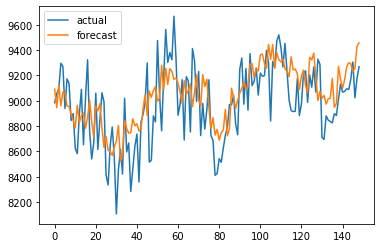

In [66]:
print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - one_step) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step, label='forecast')
plt.legend()
plt.show()